# Import Library

In [74]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import math
import json
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
np.random.seed(42)
random.seed(42)

## Model Definition

In [75]:
class ConvBlock1D(nn.Module):
    """
    Conv1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=15, s=2, p=7, bias=True, act="lrelu"):
        super().__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        else:
            raise ValueError("act must be 'lrelu' or 'relu'")

    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class DeconvBlock1D(nn.Module):
    """
    ConvTranspose1d -> BatchNorm1d -> Activation
    """
    def __init__(self, in_ch, out_ch, k=4, s=2, p=1, bias=True, act="relu"):
        super().__init__()
        self.deconv = nn.ConvTranspose1d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=bias)
        self.norm = nn.BatchNorm1d(out_ch)

        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        else:
            raise ValueError("act must be 'relu' or 'lrelu'")

    def forward(self, x):
        return self.act(self.norm(self.deconv(x)))


class ResBlock1D(nn.Module):
    """
    Residual block: (Conv -> BN -> ReLU) x2 + skip
    Keeps same channel count and length.
    """
    def __init__(self, ch, k=7, p=3, bias=True):
        super().__init__()
        self.c1 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n1 = nn.BatchNorm1d(ch)
        self.c2 = nn.Conv1d(ch, ch, kernel_size=k, stride=1, padding=p, bias=bias)
        self.n2 = nn.BatchNorm1d(ch)

    def forward(self, x):
        h = F.relu(self.n1(self.c1(x)))
        h = self.n2(self.c2(h))
        return F.relu(x + h)
    
class MultiScaleResBlock1D(nn.Module):
    """
    Multi-scale residual block: parallel conv branches (k=3,5,7) then fuse.
    Keeps same channel count and length.
    """
    def __init__(self, ch, bias=True):
        super().__init__()

        self.b3 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=3, padding=1, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b5 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=5, padding=2, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )
        self.b7 = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=7, padding=3, bias=bias),
            nn.BatchNorm1d(ch),
            nn.ReLU(inplace=True),
        )

        self.fuse = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size=1, bias=bias),
            nn.BatchNorm1d(ch),
        )

    def forward(self, x):
        h = self.b3(x) + self.b5(x) + self.b7(x)
        h = self.fuse(h)
        return F.relu(x + h)



In [76]:
# NN Generator (U-Net-ish + Res bottleneck)
class GeneratorCNNWGAN(nn.Module):
    """
    CNN U-Net-ish generator for EEG denoising (WGAN).
    Input : (B, 1, 512) noisy_norm
    Output: (B, 1, 512) clean_norm_hat
    """
    def __init__(self, base_ch=32, bottleneck_blocks=4, bias=True):
        super().__init__()

        # Encoder
        self.e1 = ConvBlock1D(1, base_ch,       k=16, s=2, p=7, bias=bias, act="lrelu")      # 512 -> 256
        self.e2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.e3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.e4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32

        # Bottleneck
        bn_ch = base_ch * 8
        self.bottleneck = nn.Sequential(*[
            ResBlock1D(bn_ch, k=7, p=3, bias=bias) for _ in range(bottleneck_blocks)
        ])

        # Decoder (concat doubles channels)
        self.d1 = DeconvBlock1D(bn_ch, base_ch*4,   k=4, s=2, p=1, bias=bias, act="relu")     # 32 -> 64
        self.d2 = DeconvBlock1D(base_ch*8, base_ch*2, k=4, s=2, p=1,bias=bias, act="relu")   # 64 -> 128
        self.d3 = DeconvBlock1D(base_ch*4, base_ch,   k=4, s=2, p=1, bias=bias, act="relu")   # 128 -> 256
        self.d4 = DeconvBlock1D(base_ch*2, base_ch//2, k=4, s=2, p=1, bias=bias, act="relu")  # 256 -> 512

        # Head (linear output recommended for normalized signals)
        self.out = nn.Conv1d(base_ch//2, 1, kernel_size=7, stride=1, padding=3, bias=bias)

    def forward(self, y):
        # Encoder
        s1 = self.e1(y)   # (B, base, 256)
        s2 = self.e2(s1)  # (B, 2b, 128)
        s3 = self.e3(s2)  # (B, 4b, 64)
        s4 = self.e4(s3)  # (B, 8b, 32)

        # Bottleneck
        b = self.bottleneck(s4)

        # Decoder + skip connections
        d1 = self.d1(b)                  # (B, 4b, 64)
        d1 = torch.cat([d1, s3], dim=1)  # (B, 8b, 64)

        d2 = self.d2(d1)                 # (B, 2b, 128)
        d2 = torch.cat([d2, s2], dim=1)  # (B, 4b, 128)

        d3 = self.d3(d2)                 # (B, b, 256)
        d3 = torch.cat([d3, s1], dim=1)  # (B, 2b, 256)

        d4 = self.d4(d3)                 # (B, b/2, 512)

        return self.out(d4)              # (B, 1, 512)

In [77]:
# Patch Critic (shared by CNN/ResCNN)
class CriticPatch1D(nn.Module):
    """
    Conditional PatchGAN critic for WGAN:
      D(y, x) -> patch scores
    y,x: (B,1,512)
    output: (B,1,32)
    """
    def __init__(self, base_ch=32, bias=True):
        super().__init__()
        self.c1 = nn.Conv1d(2, base_ch, kernel_size=16, stride=2, padding=7, bias=bias)  # 512 -> 256
        self.c2 = ConvBlock1D(base_ch, base_ch*2, k=16, s=2, p=7, bias=bias, act="lrelu")    # 256 -> 128
        self.c3 = ConvBlock1D(base_ch*2, base_ch*4, k=16, s=2, p=7, bias=bias, act="lrelu")  # 128 -> 64
        self.c4 = ConvBlock1D(base_ch*4, base_ch*8, k=16, s=2, p=7, bias=bias, act="lrelu")  # 64 -> 32
        self.out = nn.Conv1d(base_ch*8, 1, kernel_size=7, stride=1, padding=3, bias=bias)   # 32 -> 32

    def forward(self, y, x):
        h = torch.cat([y, x], dim=1)  # (B,2,512)
        h = F.leaky_relu(self.c1(h), 0.2, inplace=True)
        h = self.c2(h)
        h = self.c3(h)
        h = self.c4(h)
        return self.out(h)


# Data Import

In [78]:
ENV = "local" # or "local"

In [79]:
if ENV == "kaggle":
    EEG = np.load("/kaggle/input/eeg-denoise-net/EEG_all_epochs.npy")
    EOG = np.load("/kaggle/input/eeg-denoise-net/EOG_all_epochs.npy")
    EMG = np.load("/kaggle/input/eeg-denoise-net/EMG_all_epochs.npy")
else:
    data_path = os.path.abspath("../../data/eeg_denoise_net/")
    print(data_path)
    
    EEG = np.load(os.path.join(data_path, "EEG_all_epochs.npy"))
    EOG = np.load(os.path.join(data_path, "EOG_all_epochs.npy"))
    EMG = np.load(os.path.join(data_path, "EMG_all_epochs.npy"))

print("EEG shape:", EEG.shape)
print("EOG shape:", EOG.shape)
print("EMG shape:", EMG.shape)

c:\Users\Aryo\PersonalMade\Programming\GAN\repo\data\eeg_denoise_net
EEG shape: (4514, 512)
EOG shape: (3400, 512)
EMG shape: (5598, 512)


In [80]:
def rms(x: np.ndarray) -> float:
    """
    Root Mean Square (RMS) of a 1D signal.
    Implements Formula (3).
    """
    x = np.asarray(x)
    return np.sqrt(np.mean(x ** 2))

def snr_db(clean: np.ndarray, noise: np.ndarray) -> float:
    """
    Compute SNR in decibels.
    Implements Formula (2).
    """
    return 10 * np.log10(rms(clean) / rms(noise))

def compute_lambda(clean: np.ndarray, noise: np.ndarray, target_snr_db: float) -> float:
    """
    Compute lambda such that the mixed signal has the desired SNR (in dB).
    """
    return rms(clean) / rms(noise) * 10 ** (-target_snr_db / 10)

In [81]:
def mix_signals(clean: np.ndarray, noise: np.ndarray, target_snr_db: float):
    """
    Mix clean signal with noise at a target SNR (dB).
    
    Returns:
        mixed_signal
        lambda_used
    """
    lam = compute_lambda(clean, noise, target_snr_db)
    mixed = clean + lam * noise
    return mixed, lam

def noisy_eeg_eog(eeg: np.ndarray, eog: np.ndarray, target_snr_db: float):
    """
    EEG contaminated by ocular artifacts (EOG).
    """
    return mix_signals(eeg, eog, target_snr_db)

def noisy_eeg_emg(eeg: np.ndarray, emg: np.ndarray, target_snr_db: float):
    """
    EEG contaminated by myogenic artifacts (EMG).
    """
    return mix_signals(eeg, emg, target_snr_db)

def noisy_eeg_eog_emg(
    eeg: np.ndarray,
    eog: np.ndarray,
    emg: np.ndarray,
    target_snr_db: float,
    eog_weight: float = 1.0,
    emg_weight: float = 1.0
):
    """
    EEG contaminated by both ocular (EOG) and myogenic (EMG) artifacts.
    
    eog_weight / emg_weight allow control of relative artifact dominance.
    """
    combined_noise = eog_weight * eog + emg_weight * emg
    return mix_signals(eeg, combined_noise, target_snr_db)


In [82]:
def make_noisy_sample(
    noisy_signal,
    eeg_idx,
    eog_idx=None,
    emg_idx=None,
    snr_db=None,
    lambda_used=None
):
    return {
        "noisy": noisy_signal,      # np.ndarray (512,)
        "eeg_idx": eeg_idx,         # int
        "eog_idx": eog_idx,         # int or None
        "emg_idx": emg_idx,         # int or None
        "snr_db": snr_db,           # float
        "lambda": lambda_used       # float
    }

def sample_snr_uniform(low, high, rng):
    return rng.uniform(low, high)

def fixed_snr_list(snrs, rng):
    return rng.choice(snrs)


In [83]:
def mix_eeg_eog_paper(
    EEG,
    EOG,
    seed=42,
    mode="random"  # "exhaustive" | "random"
):
    rng = np.random.default_rng(seed)

    eeg_train_idx = np.arange(3000)
    eeg_test_idx  = np.arange(3000, 3400)

    snr_grid = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

    train_samples = []
    test_samples = []

    if mode == "exhaustive":
        # ---- training: 10x uniform SNR ----
        for _ in range(10):
            perm = rng.permutation(eeg_train_idx)
            for i in perm:
                snr = sample_snr_uniform(-7, 2, rng)
                noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

                train_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=i,
                        eog_idx=i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

        # ---- testing: fixed SNR grid ----
        for snr in snr_grid:
            for i in eeg_test_idx:
                noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

                test_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=i,
                        eog_idx=i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

    elif mode == "random":
        # ---- training: single pass, random SNR from grid ----
        for i in eeg_train_idx:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

            train_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=i,
                    eog_idx=i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

        # ---- testing ----
        for i in eeg_test_idx:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_eog(EEG[i], EOG[i], snr)

            test_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=i,
                    eog_idx=i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

    else:
        raise ValueError("mode must be 'exhaustive' or 'random'")

    return train_samples, test_samples

def mix_eeg_emg_paper(
    EEG,
    EMG,
    seed=42,
    mode="random"  # "exhaustive" | "random"
):
    rng = np.random.default_rng(seed)

    eeg_indices = rng.choice(len(EEG), size=len(EMG), replace=True)
    emg_indices = np.arange(len(EMG))

    pairs = list(zip(eeg_indices, emg_indices))
    rng.shuffle(pairs)

    train_pairs = pairs[:5000]
    test_pairs  = pairs[5000:5598]

    snr_grid = np.array([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])

    train_samples = []
    test_samples = []

    if mode == "exhaustive":
        # ---- training: 10x ----
        for _ in range(10):
            for eeg_i, emg_i in train_pairs:
                snr = sample_snr_uniform(-7, 2, rng)
                noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

                train_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=eeg_i,
                        emg_idx=emg_i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

        # ---- testing: fixed grid ----
        for snr in snr_grid:
            for eeg_i, emg_i in test_pairs:
                noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

                test_samples.append(
                    make_noisy_sample(
                        noisy,
                        eeg_idx=eeg_i,
                        emg_idx=emg_i,
                        snr_db=snr,
                        lambda_used=lam
                    )
                )

    elif mode == "random":
        # ---- training ----
        for eeg_i, emg_i in train_pairs:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

            train_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=eeg_i,
                    emg_idx=emg_i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

        # ---- testing ----
        for eeg_i, emg_i in test_pairs:
            snr = rng.choice(snr_grid)
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

            test_samples.append(
                make_noisy_sample(
                    noisy,
                    eeg_idx=eeg_i,
                    emg_idx=emg_i,
                    snr_db=snr,
                    lambda_used=lam
                )
            )

    else:
        raise ValueError("mode must be 'exhaustive' or 'random'")

    return train_samples, test_samples

def mix_custom(
    EEG,
    EOG=None,
    EMG=None,
    n_train=10000,
    n_test=2000,
    snr_range=(-7, 2),
    seed=42,
    eog_weight=1.0,
    emg_weight=1.0
):
    rng = np.random.default_rng(seed)

    samples = []

    def make_one():
        eeg_i = rng.integers(len(EEG))
        snr = rng.uniform(*snr_range)

        eog_i = None
        emg_i = None

        if EOG is not None and EMG is not None:
            eog_i = rng.integers(len(EOG))
            emg_i = rng.integers(len(EMG))
            noisy, lam = noisy_eeg_eog_emg(
                EEG[eeg_i],
                EOG[eog_i],
                EMG[emg_i],
                snr,
                eog_weight=eog_weight,
                emg_weight=emg_weight
            )

        elif EOG is not None:
            eog_i = rng.integers(len(EOG))
            noisy, lam = noisy_eeg_eog(EEG[eeg_i], EOG[eog_i], snr)

        elif EMG is not None:
            emg_i = rng.integers(len(EMG))
            noisy, lam = noisy_eeg_emg(EEG[eeg_i], EMG[emg_i], snr)

        else:
            raise ValueError("At least one of EOG or EMG must be provided.")

        return make_noisy_sample(
            noisy,
            eeg_idx=eeg_i,
            eog_idx=eog_i,
            emg_idx=emg_i,
            snr_db=snr,
            lambda_used=lam
        )

    for _ in range(n_train + n_test):
        samples.append(make_one())

    return samples[:n_train], samples[n_train:]

In [84]:
def normalize_noisy_sample(sample, EEG):
    """
    Normalize one noisy EEG sample according to EEGdenoiseNet protocol.
    
    Args:
        sample: dict produced by make_noisy_sample
        EEG: clean EEG array (for ground truth lookup)
    
    Returns:
        normalized_sample (new dict)
    """
    y = sample["noisy"]
    x = EEG[sample["eeg_idx"]]

    sigma_y = np.std(y)
    if sigma_y == 0:
        raise ValueError("Standard deviation of noisy signal is zero.")

    normalized_sample = sample.copy()
    normalized_sample.update({
        "noisy_norm": y / sigma_y,     # ŷ
        "clean_norm": x / sigma_y,     # x̂
        "sigma_y": sigma_y             # stored for rescaling later
    })

    return normalized_sample

def normalize_dataset(samples, EEG):
    """
    Normalize a list of noisy EEG samples.
    
    Args:
        samples: list of noisy sample dicts
        EEG: clean EEG array
    
    Returns:
        list of normalized sample dicts
    """
    return [normalize_noisy_sample(s, EEG) for s in samples]


# Model Import

In [85]:
BIAS = True
DATA_MODE = 5 # up to 5
SEED = 67

In [86]:
if DATA_MODE == 1: # EEG + EOG Paper
    # --- generate noisy datasets (raw, unnormalized) ---
    train_samples, test_samples = mix_eeg_eog_paper(
        EEG=EEG,
        EOG=EOG,
        seed=SEED
    )

    # --- normalize according to EEGdenoiseNet protocol ---
    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 2: # EEG + EMG Paper
    # --- generate noisy datasets (raw, unnormalized) ---
    train_samples, test_samples = mix_eeg_emg_paper(
        EEG=EEG,
        EMG=EMG,
        seed=SEED
    )

    # --- normalize ---
    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 3:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EOG=EOG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=SEED
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)
elif DATA_MODE == 4:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EMG=EMG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=SEED
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)

else:
    train_samples, test_samples = mix_custom(
        EEG=EEG,
        EOG=EOG,
        EMG=EMG,
        n_train=10000,
        n_test=2000,
        snr_range=(-7, 2),
        seed=SEED,
        eog_weight=1.0,
        emg_weight=1.0
    )

    train_samples_norm = normalize_dataset(train_samples, EEG)
    test_samples_norm  = normalize_dataset(test_samples, EEG)


In [87]:
data_path = os.path.abspath(f"checkpoints/cnn_G_d{DATA_MODE}.PTH")
print(data_path)

c:\Users\Aryo\PersonalMade\Programming\GAN\repo\src\notebooks\checkpoints\cnn_G_d5.PTH


In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = GeneratorCNNWGAN(bias=BIAS).to(device)
G.load_state_dict(torch.load(data_path, map_location=device))

print(G.eval())

GeneratorCNNWGAN(
  (e1): ConvBlock1D(
    (conv): Conv1d(1, 32, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e2): ConvBlock1D(
    (conv): Conv1d(32, 64, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e3): ConvBlock1D(
    (conv): Conv1d(64, 128, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (e4): ConvBlock1D(
    (conv): Conv1d(128, 256, kernel_size=(16,), stride=(2,), padding=(7,))
    (norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): LeakyReLU(negative_slope=0.2, inplace=True)
  

C:\Users\Aryo\AppData\Local\Temp\ipykernel_27720\2443721720.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(data_path, map_location=device))

In [89]:
def rrmse(x_hat, x):
    return torch.sqrt(torch.mean((x_hat - x) ** 2)) / torch.sqrt(torch.mean(x ** 2))


def corrcoef(x_hat, x):
    x_hat = x_hat - x_hat.mean()
    x = x - x.mean()
    return torch.sum(x_hat * x) / (
        torch.sqrt(torch.sum(x_hat ** 2)) * torch.sqrt(torch.sum(x ** 2)) + 1e-8
    )


In [90]:
@torch.no_grad()
def evaluate_wgan(
    G,
    test_samples,
    device
):
    G.eval()

    rrmse_list = []
    corr_list = []

    for s in test_samples:
        y = torch.tensor(s["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        x = torch.tensor(s["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        x_hat = G(y)

        rrmse_list.append(rrmse(x_hat, x).item())
        corr_list.append(corrcoef(x_hat, x).item())

    G.train()

    return {
        "RRMSE": float(np.mean(rrmse_list)),
        "ACC": float(np.mean(corr_list))
    }

@torch.no_grad()
def plot_example(G, sample, device):
    y = torch.tensor(sample["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    x = torch.tensor(sample["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    x_hat = G(y)

    # rescale back to original amplitude
    sigma = sample["sigma_y"]
    y_plot = y.cpu().numpy().squeeze() * sigma
    x_plot = x.cpu().numpy().squeeze() * sigma
    x_hat_plot = x_hat.cpu().numpy().squeeze() * sigma

    plt.figure(figsize=(12,4))
    plt.plot(y_plot, label="Noisy EEG", alpha=0.5)
    plt.plot(x_plot, label="Clean EEG", linewidth=2)
    plt.plot(x_hat_plot, label="Denoised (GAN)", linewidth=2)
    plt.legend()
    plt.title(f"SNR = {sample['snr_db']:.2f} dB")
    plt.show()

@torch.no_grad()
def plot_examples_grid(G, samples, device, n_examples=20, n_cols=4):
    """
    Plot multiple denoising examples in a grid.
    
    Args:
        G: trained generator
        samples: list of normalized samples (test_samples_norm)
        device: torch device
        n_examples: number of examples to plot
        n_cols: number of columns in grid
    """
    G.eval()

    n_rows = math.ceil(n_examples / n_cols)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4 * n_cols, 2.5 * n_rows),
        sharex=True,
        sharey=True
    )

    axes = axes.flatten()

    for i in range(n_examples):
        s = samples[i]

        y = torch.tensor(s["noisy_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        x = torch.tensor(s["clean_norm"], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        x_hat = G(y)

        sigma = s["sigma_y"]
        y_plot = y.cpu().numpy().squeeze() * sigma
        x_plot = x.cpu().numpy().squeeze() * sigma
        x_hat_plot = x_hat.cpu().numpy().squeeze() * sigma

        ax = axes[i]
        ax.plot(y_plot, color="gray", alpha=0.5, label="Noisy")
        ax.plot(x_plot, color="black", linewidth=1.5, label="Clean")
        ax.plot(x_hat_plot, color="tab:blue", linewidth=1.5, label="Denoised")

        ax.set_title(f"SNR = {s['snr_db']:.1f} dB", fontsize=9)
        ax.tick_params(labelsize=8)

    # turn off unused subplots
    for j in range(n_examples, len(axes)):
        axes[j].axis("off")

    # single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10, bbox_to_anchor=(0.5, 0.93))

    fig.suptitle("EEG Denoising Examples (CNN-WGAN)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    G.train()


Evaluation results:
RRMSE: 0.5628
ACC: 0.8039


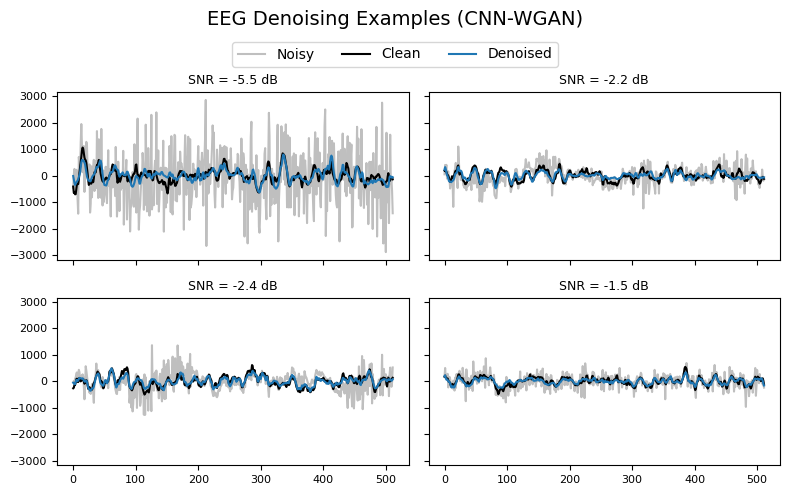

In [91]:
metrics = evaluate_wgan(
    G,
    test_samples_norm,
    device
)

print("Evaluation results:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# ---- qualitative plots ----
plot_examples_grid(
    G,
    test_samples_norm,
    device,
    n_examples=4,
    n_cols=2
)